In [25]:
from astropy.io import fits
from astropy.table import Table, Column
import numpy as np
from astropy import units as u
import os

# Load the header from the existing FITS file
# existing_fits = "template_SIMPUT.fits"  # Change this to your FITS filename
# with fits.open(existing_fits) as hdul:
#     old_header = hdul[1].header  # Assuming the table is in the first extension

# # Number of sources in the table
n_rows = 100

# Generate random values for RA and Dec within realistic ranges
ra_values = np.random.uniform(340, 351, n_rows).astype(np.float32)  # Right Ascension in degrees
dec_values = np.random.uniform(85, 88, n_rows).astype(np.float32)  # Declination in degrees

# Generate random flux values
flux_values = np.random.uniform(1e-11, 1e-10, n_rows).astype(np.float32)

# Choose models from the model_collection
model_names = np.random.choice(os.listdir("model_collection"), n_rows)

# Generate source numbers
source_numbers = np.arange(1, n_rows + 1)

# Create the new table
table = Table()
table.add_column(Column(data=source_numbers, name='SRC_ID'))
table.add_column(Column(data=ra_values, name='RA', unit=u.deg, dtype=np.float32))
table.add_column(Column(data=dec_values, name='DEC', unit=u.deg, dtype=np.float32))
table.add_column(Column(data=np.zeros(n_rows), name='IMGROTA', unit=u.deg, dtype=np.float32))
table.add_column(Column(data=np.ones(n_rows), name='IMGSCAL', unit=u.deg, dtype=np.float32))
table.add_column(Column(data=np.zeros(n_rows), name='E_MIN', unit=u.deg, dtype=np.float32))
table.add_column(Column(data=np.zeros(n_rows), name='E_MAX', unit=u.deg, dtype=np.float32))
table.add_column(Column(data=flux_values, name='FLUX', dtype=np.float32))
table.add_column(Column(data=model_names, name='SPECTRUM'))
table.add_column(Column(data=['NULL']*n_rows, name='IMAGE'))
table.add_column(Column(data=['NULL']*n_rows, name='TIMING'))

# Write the new table with the copied header
table.write("catalog1.fits", format='fits', overwrite=True)

# # Attach the old header to the new FITS file
# with fits.open("catalog1.fits", mode="update") as hdul:
#     hdul[1].header = old_header  # Copy the header
#     hdul.flush()  # Save changes

# print("New FITS table created with copied header.")
table


SRC_ID,RA,DEC,IMGROTA,IMGSCAL,E_MIN,E_MAX,FLUX,SPECTRUM,IMAGE,TIMING
,deg,deg,deg,deg,deg,deg,,,,
int64,float32,float32,float32,float32,float32,float32,float32,str29,str4,str4
1,350.4204,85.261696,0.0,1.0,0.0,0.0,4.112816e-11,Model_TBabs(bbody + apec).xcm,NULL,NULL
2,350.00082,85.16158,0.0,1.0,0.0,0.0,3.9831315e-11,Model_bbodyrad.xcm,NULL,NULL
3,350.88116,85.210625,0.0,1.0,0.0,0.0,7.10783e-11,Model_bbodyrad.xcm,NULL,NULL
4,350.13766,85.785255,0.0,1.0,0.0,0.0,9.028746e-11,Model_TBabs*bbodyrad.xcm,NULL,NULL
5,350.58386,85.64018,0.0,1.0,0.0,0.0,8.175897e-11,Model_TBabs(bbody + apec).xcm,NULL,NULL
6,350.92303,85.91041,0.0,1.0,0.0,0.0,5.199185e-11,Model_TBabs(bbody + apec).xcm,NULL,NULL
7,350.541,85.18104,0.0,1.0,0.0,0.0,4.1572835e-11,Model_TBabs(bbody + apec).xcm,NULL,NULL
8,350.1784,85.80725,0.0,1.0,0.0,0.0,9.718175e-11,Model_TBabs(bbody + apec).xcm,NULL,NULL


In [26]:
from xspec import *
Xset.chatter = 0
pretable = Table.read('catalog1.fits')
fits
lis = []
src = []
energies = []
values = []
for src_id,modelstring in enumerate(pretable['SPECTRUM'][:]):
    modelstring = modelstring.replace('Model_','').replace('.xcm','')
    # print(modelstring,src_id)
    m = Model(modelstring)
    src.append(str(src_id))
    energies.append(m.energies(0)[1:]) #take the center of the bins
    values.append(m.values(0))
    # m,energies,values
    # lis.append([m,energies,values])
c1 = fits.Column(name='NAME', array=src, format='100A')
c2 = fits.Column(name='ENERGY', array=energies, format=f'{len(energies[0])}D')
c3 = fits.Column(name='FLUXDENSITY',array=values, format=f'{len(values[0])}D')

t = fits.BinTableHDU.from_columns([c1,c2,c3])
t.data
t.writeto('spec_info.fits')

from astropy.io import fits
with fits.open('catalog1.fits') as first_hdul:
    first_hdul.append(t)
    first_hdul.writeto('final.fits')

    

In [27]:
with open('src_merged.fits') as hdul:
    header1 = hdul[0].header
    print(header1)

TypeError: '_io.TextIOWrapper' object is not subscriptable

In [109]:
from astropy.table import Table
t = Table.read('final.fits', hdu=1)
specnames = []
for id in t['SRC_ID']:
    specnames.append(f"[SPECTRUM,1][NAME=='{id}']")

with fits.open('final.fits') as finalhdul:
    finalhdul

# t['SPECTRUM'] = ['genericspec.fits']*len(t)



SRC_ID,RA,DEC,IMGROTA,IMGSCAL,E_MIN,E_MAX,FLUX,SPECTRUM,IMAGE,TIMING
,deg,deg,deg,deg,deg,deg,,,,
int64,float32,float32,float32,float32,float32,float32,float32,str16,bytes4,bytes4
1,350.70505,85.11276,0.0,1.0,0.0,0.0,6.2054785e-11,genericspec.fits,NULL,NULL
2,350.73517,85.546326,0.0,1.0,0.0,0.0,2.1426597e-11,genericspec.fits,NULL,NULL
3,350.61664,85.147736,0.0,1.0,0.0,0.0,8.9426154e-11,genericspec.fits,NULL,NULL
4,350.9864,85.8118,0.0,1.0,0.0,0.0,2.6592015e-11,genericspec.fits,NULL,NULL
5,350.98767,85.58806,0.0,1.0,0.0,0.0,9.608931e-11,genericspec.fits,NULL,NULL
6,350.91403,85.13785,0.0,1.0,0.0,0.0,3.532557e-11,genericspec.fits,NULL,NULL
7,350.4342,85.322464,0.0,1.0,0.0,0.0,9.653062e-11,genericspec.fits,NULL,NULL
8,350.416,85.50576,0.0,1.0,0.0,0.0,6.5612286e-11,genericspec.fits,NULL,NULL


In [112]:
from xspec import *
Xset.abund = 'wilm'
m = Model('tbabs*bbodyrad')
m.energies(0)
m.values(0)
Table([m.values(0),m.energies(0)[1:]], names=['values', 'energies']).write('genericspec.fits')

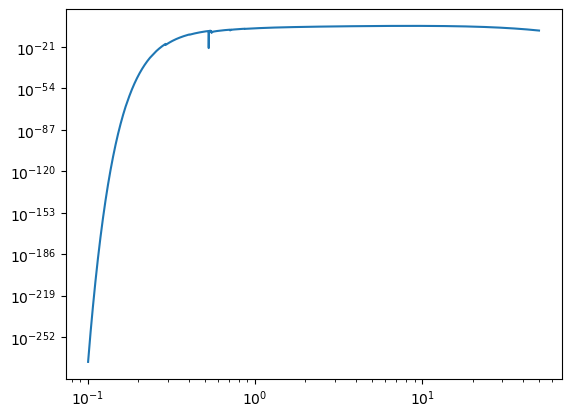

In [25]:
from matplotlib import pyplot  as plt

plt.plot(m.energies(0)[1:],m.values(0))
plt.xscale('log')
plt.yscale('log')

In [16]:
from 

SyntaxError: invalid syntax (681706079.py, line 1)